### Imports

In [42]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [10]:
# Download the dataset from UCI
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2024-10-20 11:58:14--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'bank+marketing.zip.2'

     0K .......... .......... .......... .......... ..........  126K
    50K .......... .......... .......... .......... ..........  261K
   100K .......... .......... .......... .......... .......... 7.22M
   150K .......... .......... .......... .......... ..........  381K
   200K .......... .......... .......... .......... ..........  605K
   250K .......... .......... .......... .......... .......... 4.54M
   300K .......... .......... .......... .......... ..........  279K
   350K .......... .......... .......... .......... .......... 5.42M
   400K .......... .......... .......... .......... .......... 1.33M
   450K .......... ........

In [22]:
# Unzip the outer zip file
with zipfile.ZipFile('bank+marketing.zip', 'r') as outer_zip:
    # Extract 'bank-additional.zip' from the outer zip file
    with outer_zip.open('bank.zip') as inner_zip_file:
        with zipfile.ZipFile(inner_zip_file) as inner_zip:
            # List files in the inner zip to identify the correct CSV path
            print(inner_zip.namelist())

            # After reviewing the structure, adjust the path to the CSV file
            df = pd.read_csv(inner_zip.open('bank-full.csv'), sep=';')

# Display the first few rows of the dataframe
df.head()

['bank-full.csv', 'bank-names.txt', 'bank.csv']


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Dataset preparation

In [24]:
# List of columns to keep
columns_needed = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 
    'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]

# Filter df with the specified columns
df_filtered = df[columns_needed]

# Split the data into 60% train and 40% temp (validation + test)
df_train, df_temp = train_test_split(df_filtered, test_size=0.4, random_state=1)

# Now split the temp set into 50% validation and 50% test (which will be 20% each of the original dataset)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

# Output the sizes of the splits to verify
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 27126
Validation size: 9042
Test size: 9043


## Question 1

In [27]:
# Numerical variables to evaluate
numerical_vars = ['balance', 'day', 'duration', 'previous']

# Dictionary to store the AUCs
auc_scores = {}

# Iterate over each numerical variable
for var in numerical_vars:
    # Compute AUC
    auc = roc_auc_score(df_train['y'].apply(lambda x: 1 if x == 'yes' else 0), df_train[var])
    
    # If AUC is below 0.5, negate the variable
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'].apply(lambda x: 1 if x == 'yes' else 0), -df_train[var])
    
    # Store the AUC in the dictionary
    auc_scores[var] = auc
    print(f"AUC for {var}: {auc}")

# Find the variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: {highest_auc_var}")

AUC for balance: 0.5916931412945473
AUC for day: 0.5291275984648961
AUC for duration: 0.8128648066681694
AUC for previous: 0.5986704105715122

The numerical variable with the highest AUC is: duration


## Question 2

In [29]:
# Prepare categorical and numerical features
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# One-hot encode categorical variables using DictVectorizer
dv = DictVectorizer(sparse=False)

# Convert training data to a list of dictionaries
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

In [30]:
# Fit DictVectorizer on training data and transform both train and validation sets
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Target variable
y_train = df_train['y'].apply(lambda x: 1 if x == 'yes' else 0)
y_val = df_val['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate the AUC on the validation set
auc = roc_auc_score(y_val, y_pred)

# Output the AUC rounded to 3 digits
print(f"AUC on validation set: {auc:.3f}")

AUC on validation set: 0.900


## Question 3

In [32]:
# Define thresholds from 0.0 to 1.0 using np.linspace
thresholds = np.linspace(0.0, 1.0, 101)

In [37]:
# Initialize lists to store precision and recall values
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities into binary predictions based on the threshold
    y_pred_thresholded = (y_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_thresholded, zero_division=1)
    recall = recall_score(y_val, y_pred_thresholded)
    
    precisions.append(precision)
    recalls.append(recall)

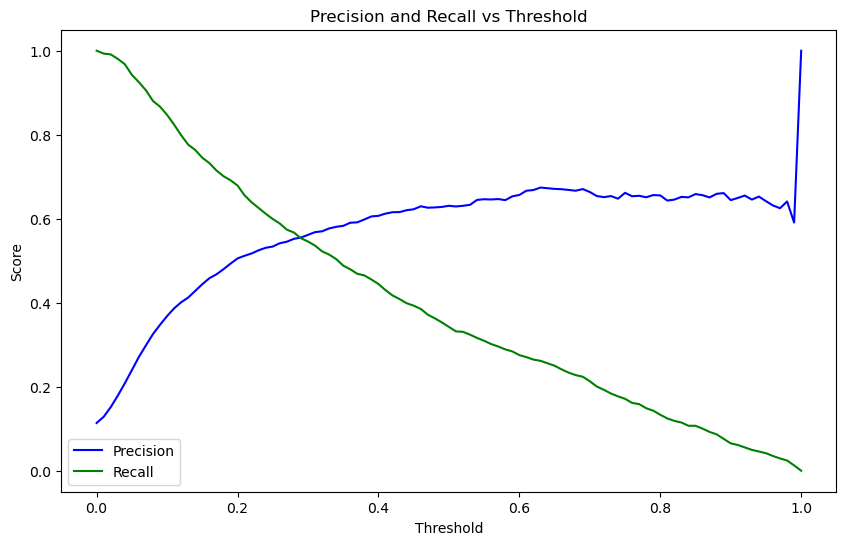

In [38]:
# Plot precision and recall against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')
plt.show()

We can see the intersection of the two lines happens between 0.2 and 0.3 thresholds.

## Question 4

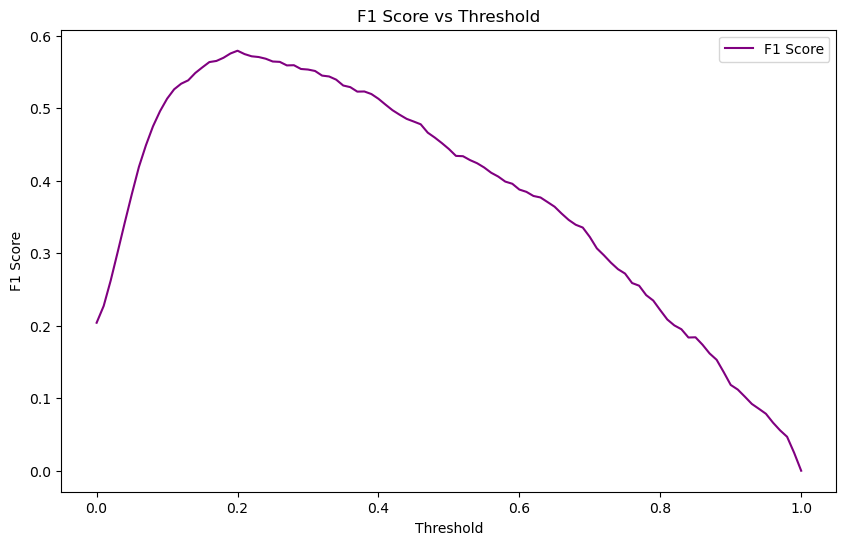

In [39]:
# Initialize list to store F1 scores
f1_scores = []

# Calculate F1 score for each threshold
for precision, recall in zip(precisions, recalls):
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

# Plot F1 score against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend(loc='best')
plt.show()

In [40]:
# Find the threshold where F1 is maximal
max_f1 = max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Threshold with the highest F1 score: {best_threshold:.2f}")
print(f"Maximum F1 score: {max_f1:.3f}")

Threshold with the highest F1 score: 0.20
Maximum F1 score: 0.579


## Question 5

In [43]:
# Full training dataset
df_full_train = pd.concat([df_train, df_val])

# Target variable
y_full = df_full_train['y'].apply(lambda x: 1 if x == 'yes' else 0)

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [44]:
# Initialize list to store AUC scores
auc_scores = []

# Iterate over each fold
for train_index, val_index in kf.split(df_full_train):
    # Split into training and validation based on the fold indices
    df_train_fold = df_full_train.iloc[train_index]
    df_val_fold = df_full_train.iloc[val_index]

    # Prepare features
    train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
    val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict)
    X_val_fold = dv.transform(val_dict)

    y_train_fold = y_full.iloc[train_index]
    y_val_fold = y_full.iloc[val_index]

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation fold
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]

    # Calculate AUC for the current fold
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)

# Calculate standard deviation of the AUC scores
std_auc = np.std(auc_scores)

print(f"AUC scores for each fold: {auc_scores}")
print(f"Standard deviation of AUC scores: {std_auc:.6f}")

AUC scores for each fold: [0.9045149038971269, 0.9022377945369395, 0.9094985697047692, 0.9135177280177769, 0.9009110105580693]
Standard deviation of AUC scores: 0.004710


## Question 6

In [45]:
# Hyperparameter values for C
C_values = [0.000001, 0.001, 1]

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store the mean and std for each C
results = []

# Iterate over the different C values
for C in C_values:
    auc_scores = []
    
    # Iterate over each fold in KFold
    for train_index, val_index in kf.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_index]
        df_val_fold = df_full_train.iloc[val_index]

        # Prepare features
        train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
        val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dict)
        X_val_fold = dv.transform(val_dict)

        y_train_fold = y_full.iloc[train_index]
        y_val_fold = y_full.iloc[val_index]

        # Train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation fold
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores.append(auc)
    
    # Compute mean and std of the AUC scores for this value of C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store the results
    results.append((C, mean_auc, std_auc))

In [47]:
# Sort results by mean_auc (descending), then std_auc (ascending), then by smallest C
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))

# Output the results
for C, mean_auc, std_auc in results_sorted:
    print(f"C={C}, Mean AUC={mean_auc:.3f}, Std AUC={std_auc:.3f}")

# Best C based on the criteria
best_C, best_mean_auc, best_std_auc = results_sorted[0]
print(f"\nBest C: {best_C}, with Mean AUC: {best_mean_auc:.3f} and Std AUC: {best_std_auc:.3f}")

C=1, Mean AUC=0.906, Std AUC=0.005
C=0.001, Mean AUC=0.861, Std AUC=0.002
C=1e-06, Mean AUC=0.697, Std AUC=0.007

Best C: 1, with Mean AUC: 0.906 and Std AUC: 0.005
